# Drone Model-Predictive Control

## Package Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from pydrake.all import (
    AbstractValue, AddMultibodyPlantSceneGraph,ConstantVectorSource, BasicVector,BallRpyJoint,
    DiagramBuilder,DirectCollocation, DirectTranscription, MathematicalProgram,
    FiniteHorizonLinearQuadraticRegulatorOptions, FindResourceOrThrow, LinearSystem, Linearize, 
    LeafSystem_,ExternallyAppliedSpatialForce_, LeafSystem,ExternallyAppliedSpatialForce, 
    LogVectorOutput, MultibodyPlant, MakeFiniteHorizonLinearQuadraticRegulator, MultibodyPlant,
    MathematicalProgram, MeshcatVisualizerParams, MeshcatVisualizerCpp, Parser, PortDataType,
    plot_system_graphviz, Propeller, PropellerInfo, PiecewisePolynomial, RandomSource, 
    RandomDistribution, PrismaticJoint, RigidBody, RigidTransform, Role, RotationMatrix, 
    SceneGraph, Simulator, Solve, StartMeshcat, SpatialInertia, SolverOptions, CommonSolverOption,
    TrajectorySource, Trajectory, TimeStep, UnitInertia, VectorSystem, TemplateSystem, UnitInertia, eq)

from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController)

from underactuated.meshcat_cpp_utils import MeshcatSliders

from pydrake.multibody.plant import Wing





## Start Meshcat Visualizer

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()
# define starting figure number
fig_num = 0;

INFO:drake:Meshcat listening for connections at https://252d90d3-1ad4-4a56-8b32-ebf5b097846b.deepnoteproject.com/7000/


## Define the Obstacle class 

In [3]:
class Obstacle():

    def __init__(self, sdf, p, body_name, height, width, depth):

        self.sdf = sdf
        self.position = p
        self.body_name = body_name
        self.height = height
        self.width = width
        self.depth = depth


    #parse sdf file to instantiate object and weld it to the simulation world
    def connect_obstacle_to_world(self, obstacle_plant, scene_graph):

        parser = Parser(obstacle_plant, scene_graph)

        self.model_instance = parser.AddModelFromFile(self.sdf)
        self.body = obstacle_plant.GetBodyByName(self.body_name, self.model_instance)
        obstacle_plant.WeldFrames(obstacle_plant.world_frame(), self.body.body_frame(), RigidTransform(p=self.position))

    # calculate 3D distance vector from quadrotor to object
    # quad_state parameter is truncated version of full state [x,y,z]
    def distance_from_object(self, quad_state):
        return quad_state - self.position

    def detect_collision(self, quad_context):
        quad_state = quad_context.get_continuous_state().get_vector().CopyToVector()
        # print(quad_state)
        dist = self.distance_from_object(quad_state[:3])

        if (np.linalg.norm(dist)  <= 1.0 ):
            return True
        else:
            return False



## Define Offline Trajectory Optimization Class

Find an optimal trajectory from an initial condition to a target destination, that minimizes time to target destination, and adheres to thrust limits

In [4]:
class QuadrotorTrajOpt():

    def __init__(self, init_state, target_state, num_time_samples, thrust_limit):
        self.init_state = init_state
        self.target_state = target_state
        self.num_time_samples = num_time_samples
        self.thrust_limit = thrust_limit


    def dir_col_opt(self, quadrotor_plant, quadrotor_context, obstacle_list):

        # use direct collocation to integrate quadrotor dynamics
        # DirectCollation classe performs Direct transcription trajectory optimization using nonlinear programming and collocation
        # It assumes a first-order hold on the input trajectory and a cubic spline representation of the state trajectory, and adds dynamic constraints 
        # (and running costs) to the midpoints as well as the breakpoints in order to achieve a 3rd order integration accuracy.
        dircol = DirectCollocation(quadrotor_plant,
                                quadrotor_context,
                                num_time_samples=self.num_time_samples,
                                minimum_timestep=0.05,
                                maximum_timestep=0.2)

        #Returns a reference to the MathematicalProgram associated with the trajectory optimization problem.
        prog = dircol.prog()

        # add constraint that enforces that all timesteps have equal duration (ensures more efficient optimization)
        dircol.AddEqualTimeIntervalsConstraints()

        # Returns placeholder decision variables (not actually declared as decision variables in the MathematicalProgram) 
        # associated with the input, u, but with the time-index undetermined.
        u = dircol.input()

        x = dircol.state()

        print(f"state = {x}")
        print(f"input = {u}")

        #TODO: constrain roll, pitch & yaw to be below 90

        # enforce collision avoidance constraints for each obstacle

        for obs in obstacle_list:
            # pass [x,y,z] position of quadrotor to get distance vector 
            quad_state_xyz = x[:3]
            distance_vector = obs.distance_from_object(quad_state_xyz)
            #x distance from center of object
            dircol.AddConstraintToAllKnotPoints(np.linalg.norm(distance_vector) >= 1.0 )
        
        #enforce constraint that drone cannot fly underground
        dircol.AddConstraintToAllKnotPoints(x[2]>= 0.0)

        #enforce constraint drone cannot fly above tree line
        dircol.AddConstraintToAllKnotPoints(x[2]<= 1.0)

        # # enforce individual thrust limits for each propellor
        dircol.AddConstraintToAllKnotPoints(u[0] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[0])

        dircol.AddConstraintToAllKnotPoints(u[1] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[1])

        dircol.AddConstraintToAllKnotPoints(u[2] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[2])

        dircol.AddConstraintToAllKnotPoints(u[3] <= self.thrust_limit)
        dircol.AddConstraintToAllKnotPoints(-self.thrust_limit <= u[3])

        # add initial state constraint (first parameter is upper bound, second parameter is lower bound, 3rd parameter is variable being constrained)
        prog.AddBoundingBoxConstraint(self.init_state, self.init_state,
                                    dircol.initial_state())

        # add final state constraint
        prog.AddBoundingBoxConstraint(self.target_state, self.target_state,
                                    dircol.final_state())


        # Add quadratic cost on difference between current state and target state
        # Q = [10.,10.,10.,10.,10.,10.,1.,1.,1.,1.,1.,1.]
        # for i in range(len(x)):
        #     dircol.AddRunningCost( Q[i]* (x[i] -  self.target_state[i])**2)

        R = 1  # Cost on input "effort".
        dircol.AddRunningCost(R * u[0]**2)
        dircol.AddRunningCost(R * u[1]**2)
        dircol.AddRunningCost(R * u[2]**2)
        dircol.AddRunningCost(R * u[3]**2)


        # # add contraints on angle 
        # angle_limit = 85
        # dircol.AddConstraintToAllKnotPoints(x[3] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[3])
        # dircol.AddConstraintToAllKnotPoints(x[4] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[4])
        # dircol.AddConstraintToAllKnotPoints(x[5] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[5])
        # dircol.AddConstraintToAllKnotPoints(x[6] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[6])
        # dircol.AddConstraintToAllKnotPoints(x[7] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[7])
        # dircol.AddConstraintToAllKnotPoints(x[8] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[8])
        # dircol.AddConstraintToAllKnotPoints(x[9] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[9])
        # dircol.AddConstraintToAllKnotPoints(x[10] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[10])
        # dircol.AddConstraintToAllKnotPoints(x[11] <= angle_limit)
        # dircol.AddConstraintToAllKnotPoints(-angle_limit <= x[11])


        # Add a final cost equal to the total duration.
        dircol.AddFinalCost(dircol.time())

        # Construct an initial guess at an optimal trajectory
        # PiecewisePolynomial.FirstOrderHold Constructs a piecewise linear PiecewisePolynomial using matrix samples.
        breaks = [0., 4.]
        samples = np.column_stack((self.init_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(breaks, samples)  # yapf: disable

        dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

        result = Solve(prog)
        assert (result.is_success())

        u_trajectory = dircol.ReconstructInputTrajectory(result)
        x_trajectory = dircol.ReconstructStateTrajectory(result)

        return u_trajectory, x_trajectory

    def create_lqr_stabilizer(self, x_trajectory, u_trajectory, quadrotor_plant, quadrotor_context):
        options = FiniteHorizonLinearQuadraticRegulatorOptions()
        options.x0 = x_trajectory
        options.u0 = u_trajectory
        
        #define state penalty matrix with a 10 to 1 ratio on positions vs velocites
        #[x,y,z,roll,pitch,yaw, xdot, ydot, zdot, rolldot, pitchdot, yawdot]
        Q = np.diag([10.,10.,10.,10.,10.,10.,1.,1.,1.,1.,1.,1.])

        #final cost matrix
        options.Qf = Q
        # there are 4 thrust inputs, add minimum penalty to thrust
        # R = np.eye(4)
        R = np.diag([10,10,10,10])

        lqr_regulator = MakeFiniteHorizonLinearQuadraticRegulator(quadrotor_plant,
                                                  quadrotor_context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=R,
                                                  options=options)
        return lqr_regulator, options



## Define MPC Controller Class

In [5]:
class MpcController(VectorSystem):

    def __init__(self, quadrotor_plant, init_state, target_state, time_horizon, 
                max_time_samples, thrust_limit, obstacle_list, u0, time_step):
        # define this system as having 12 inputs and 4 outputs
        VectorSystem.__init__(self, 12, 4)
        self.quadrotor_plant = quadrotor_plant
        self.init_state = init_state
        self.target_state = target_state
        self.time_horizon = time_horizon
        self.max_time_samples = max_time_samples
        self.thrust_limit = thrust_limit
        self.obstacle_list = obstacle_list
        self.current_step = 0

        self.current_output = u0
        
        self.time_step = time_step

        # initialize optimization
        self.prog = MathematicalProgram()





    def set_sim_context(self, sim_context):
        self.sim_context = sim_context


    def quadrotor_discrete_dynamics(self, A, B, state, state_next, thrust, time_step):
        '''This method assumes quadrotor dynamics have been linearized, and A & B 
        matrices have been passed in from linear quadrotor'''

        # continuous-time dynamics evaluated at the next time step
        # in the form state_dot_continous = f(state, thrust)
        state_dot_continous = A.dot(state_next) + B.dot(thrust)

        # implicit-Euler state update
        # enforce x[n+1] = x[n] + f(x[n], u[n]) * time_step
        residuals = state_next - state - time_step * state_dot_continous

        return residuals


    # generate initial guess of x trajectory by interpolating between current state and target
    def generate_initial_guess(self, current_state, target_state, num_samples, time_interval ):
        # np.random.seed(0)

        time_limits = [0., num_samples * time_interval ]
        state_samples = np.column_stack((self.init_state, self.target_state))
        initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(time_limits, state_samples)

        # sample state on the time grid and add small random noise
        x_trajectory_guess = np.vstack([initial_x_trajectory.value(t * time_interval).T for t in range(num_samples + 1)])
        # x_trajectory_guess += np.random.rand(*x_trajectory_guess.shape) * 5e-6

        return x_trajectory_guess

    def DoCalcVectorOutput(self, context, inp, state, output):

        # quadrotor_mutable_context = self.quadrotor_plant.GetMyMutableContextFromRoot(self.sim_context)
        quadrotor_context = self.quadrotor_plant.CreateDefaultContext()

        # fix input port of quadrotor with output of MPC controller, in order to perform linearization
        # this is the output from the previous iteration of the sim
        self.quadrotor_plant.get_input_port(0).FixValue(quadrotor_context, self.current_output)

        # input into the controller is the state of the quadrotor
        # set the context equal to the current state
        quadrotor_context.SetContinuousState(inp)
        current_state = inp

        ##################
        # Linearize system dynamics - Take first order taylor series expansions of system
        # around the operating point defined by quadrotor context
        ##################
        eq_check_tolerance = 10e6 # we do not need to be at an equilibrium point
        linear_quadrotor = Linearize(self.quadrotor_plant, quadrotor_context, \
        equilibrium_check_tolerance = eq_check_tolerance )

        #### get A & B matrices of linearized continuous dynamics
        A = linear_quadrotor.A()
        B = linear_quadrotor.B()

        # print(f"len A = {len(A)}")
        # print(f"len B = {len(B)}")
        # print(f"A = {A}")
        # print(f"B = {B}")

        # number of time steps in optimization should decrease as we get closer to target
        # num_samples = min(self.time_horizon, self.max_time_samples - self.current_step +1)
        num_samples = self.time_horizon

        # print(f"cur_quad_state = {current_state}")
        # print(f"quadrotor current input = {self.current_output}")
        # print(f"num_samples = {num_samples}")
        # print(f"target_state = {self.target_state}")

        # optimization variables
        # input to controller is state, x
        self.x = self.prog.NewContinuousVariables(self.time_horizon + 1, 12, 'state')
        # output from controller is thrust, u
        self.u = self.prog.NewContinuousVariables(self.time_horizon, 4, 'thrust')

        ## Add starting state constraint based on current state
        self.prog.AddBoundingBoxConstraint(current_state, current_state, self.x[0,:])


        ### add quadratic cost on state error ###
        Q = 10*np.diag([100.,100.,100.,100.,100.,100.,10.,10.,10.,10.,10.,10.])
        #### Add quadratic cost on input effort ###
        R = np.diag([1.,1.,1.,1.,])

        for t in range(num_samples):
            
            # calculate residual using Implicit Euler integration
            residuals = self.quadrotor_discrete_dynamics(A, B, self.x[t], 
            self.x[t+1], self.u[t], self.time_step)
            for residual in residuals:
                self.prog.AddLinearConstraint(residual == 0)

            # calculate quadratic state error cost
            # error  = self.x[t] - self.target_state
            # self.prog.AddCost(error.T.dot(Q.dot(error)) )
            self.prog.AddQuadraticErrorCost(Q, self.target_state, self.x[t])

            self.prog.AddCost(self.u[t].dot(R.dot(self.u[t])))


        #### Define initial guess trajectory by linearly interpolating between current state and target 
        initial_x_trajectory = self.generate_initial_guess(current_state, self.target_state, 
            num_samples, self.time_step )

        self.prog.SetInitialGuess(self.x, initial_x_trajectory)

        # solver_options = SolverOptions()
        # solver_options.SetOption(CommonSolverOption.kPrintFileName, "/work/solver_mpc_diag.txt")
        # self.prog.SetSolverOptions(solver_options)

        # print("running solver")
        result = Solve(self.prog)
        assert (result.is_success())

        # # retrieve optimal solution
        u_trajectory = result.GetSolution(self.u)
        # x_trajectory = result.GetSolution(x)
        
        # plt.figure(fig_num)
        # plt.title('x_trajectory - z_position')
        # plt.plot(np.linspace(0, num_samples+1, num = num_samples+1), x_trajectory[:,2], 'b')
        # plt.ylabel('z position', color='b')
        # plt.xlabel('time_sample')
        # plt.show()

        #### set output to first step of thrust trajectory ###
        print(u_trajectory[0])
        output[:] = u_trajectory[0]

        # output[:] = [10.,10.,10.,10.]
        self.current_output = output
        print(output)

        ##### increment current timestep
        self.current_step += 1

        # for t in range(num_samples):
        #     error  = x[t] - self.target_state
        #     print(f"x - x_desired = {error}")
        #     self.prog.AddCost(error.T.dot(Q.dot(error)) )
        #     # self.prog.AddQuadraticErrorCost(Q, self.target_state, x[t])


        #calculate residual using Implicit Euler integration
        # residuals = self.quadrotor_discrete_dynamics(linear_quadrotor.A(), linear_quadrotor.B(), x[t], 
        #     x[t+1], u[t], self.time_step)
        # for residual in residuals:
        #     self.prog.AddConstraint(residual == 0)


        # # add obstacle constraints
        # for t in range(num_samples):
        #     for obs in self.obstacle_list:
        #         quad_state_xyz = x[t,:3]
        #         distance_vector = obs.distance_from_object(quad_state_xyz)
        #         self.prog.AddConstraint(np.linalg.norm(distance_vector) >= 1.0 )

        # # add state constraints 
        # for t in range(num_samples):
        #     # stay above ground
        #     self.prog.AddLinearConstraint(x[t,2] >= 0 )
        #     #stay below treee line
        #     self.prog.AddLinearConstraint(x[t,2] <= 3 )
        # for t in range(num_samples):
        #     self.prog.AddConstraint((u[t,:].dot(u[t,:])) <= self.thrust_limit**2 )

        # for t in range(num_samples):
        #     self.prog.AddLinearConstraint(u[t,0] <= self.thrust_limit)
        #     self.prog.AddLinearConstraint(u[t,0] >= -self.thrust_limit)
        #     self.prog.AddLinearConstraint(u[t,1] <= self.thrust_limit)
        #     self.prog.AddLinearConstraint(u[t,1] >= -self.thrust_limit)
        #     self.prog.AddLinearConstraint(u[t,2] <= self.thrust_limit)
        #     self.prog.AddLinearConstraint(u[t,2] >= -self.thrust_limit)
        #     self.prog.AddLinearConstraint(u[t,3] <= self.thrust_limit)
        #     self.prog.AddLinearConstraint(u[t,3] >= -self.thrust_limit)

        # Q = [100.,100.,100.,100.,100.,100.,10.,10.,10.,10.,10.,10]


        # add additive quadratic cost on difference between current state and target state
        
        # for t in range(num_samples):
        #     error  = x[t] - self.target_state
        #     print(f"x - x_desired = {error}")
        #     self.prog.AddCost(error.T.dot(Q.dot(error)) )
        #     # self.prog.AddQuadraticErrorCost(Q, self.target_state, x[t])

        # R = [1.,1.,1.,1.,]  # Cost on input "effort".





        
        # R = 10



        # minimize total thrust
        # self.prog.AddCost(self.time_step * sum(t.dot(t) for t in u))

        # for t in range(num_samples):
        #     self.prog.AddCost(R*u[t,0])
        #     self.prog.AddCost(R*u[t,1])
        #     self.prog.AddCost(R*u[t,2])
        #     self.prog.AddCost(R*u[t,3])



        #TODO: contrain roll, pitch & yaw to be below 90

        # # TODO: Add recursive feasibility constraint



        # plt.figure(fig_num)
        # plt.title('initial guess x_trajectory - z_position')
        # plt.plot(np.linspace(0, num_samples+1, num = num_samples+1), initial_x_trajectory[:,2], 'b')
        # plt.ylabel('z position', color='b')
        # plt.xlabel('time_sample')
        # plt.show()




## Dryden Wind Turbulence Model

altitude in region 3: > 2000 ft
sigma_u = 10.125, L_u = 1750
sigma_v = 10.125, L_v = 1750 
sigma_w = 10.125, L_w = 1750 
vehicle_speed = 20


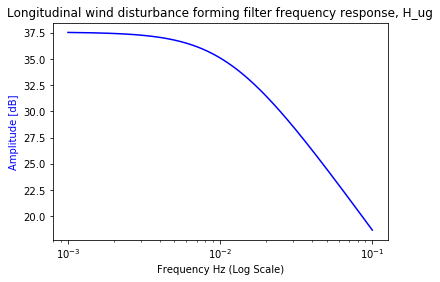

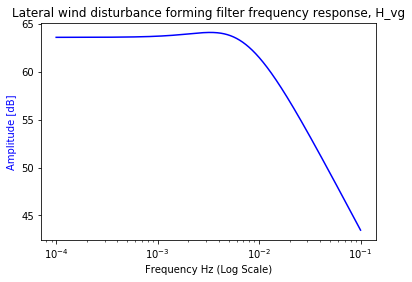

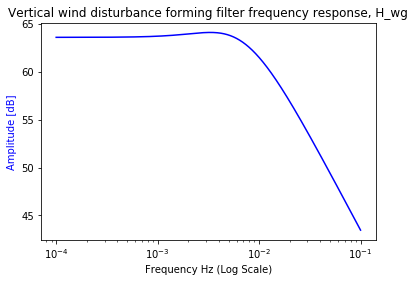

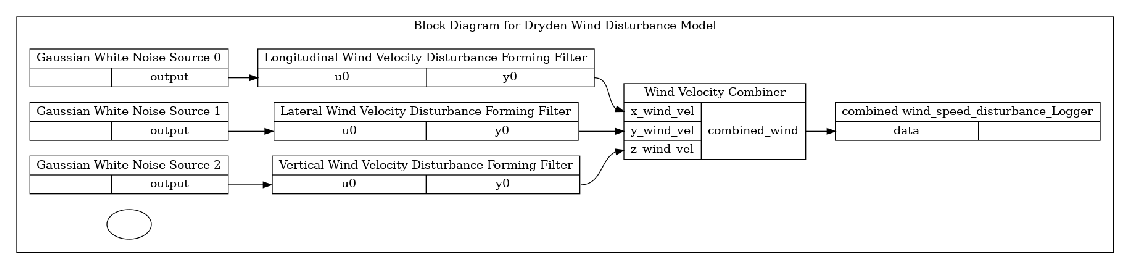

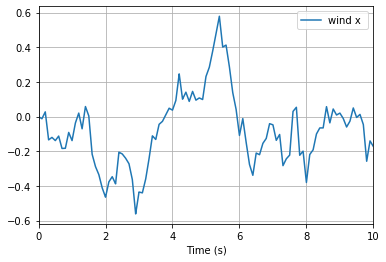

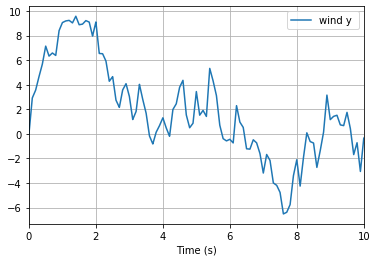

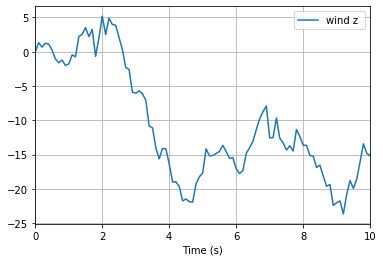

In [6]:
# the dryden noise cl
class WindCombiner(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("x_wind_vel", 1)
        self.DeclareVectorInputPort("y_wind_vel", 1)
        self.DeclareVectorInputPort("z_wind_vel", 1)

        self.DeclareVectorOutputPort("combined_wind", 3, self.CombineWind)

    def CombineWind(self, context, output):
        x_wind_vel = self.EvalVectorInput(context, 0)[0]
        y_wind_vel = self.EvalVectorInput(context, 1)[0]
        z_wind_vel = self.EvalVectorInput(context, 2)[0]

        output.set_value([x_wind_vel, y_wind_vel, z_wind_vel])


        



class DrydenWindDisturbance:

    '''Generate colored noise used to represent wind turbulence using the Dryden Wind Disturbance Model.'''

    def __init__(self, sampling_interval):

        # define the number of outputs for the gaussian noise source used to generate 
        # Dryden wind disturbance
        self.sampling_interval = sampling_interval

    def calculate_model_parameters(self, altitude, wind_speed):
        #########################
        # turbulence intensities( sigma_u, sigma_v, sigma_w), and turbulence lengths (L_u, L_v, L_w) are 
        # functions of altitude h, divided into three regions:
        #
        # wind_speed = 15 knots for light turbulence, 30 knots for moderate turbulence, 
        # 45 knots for severe turbulence
        #
        # units of altitude in ft



        ######################## Region 1: altitude < 1000
        if (altitude < 1000):

            sigma_w = 0.1 * wind_speed
            
            sigma_v  = sigma_w / ( (0.177 + 0.000823* altitude) ** 0.4 )

            sigma_u = sigma_v

            L_w = altitude

            L_v = altitude / ( (0.177 + 0.000823* altitude) ** 1.2 )

            L_u = L_v

        ######################### Region 2: 1000 < altitude < 2000
        # Calculated be performing linear interpolation between regions 1 & 3

        elif (1000 <= altitude <= 2000):
            print("altitude in region 2: 1000 - 2000 ft, not implemented")
            # typically implemented as linear interpolation between parameter values in high altitude region 
            # and parameter values in the low altitude region
            # not implemented, as this project is only concerned with high altitude region

        ######################### Region 3: altitude > 2000
        else:
            print("altitude in region 3: > 2000 ft")
            # in this region, turbulence is assumed isotropic, which leads to turbulence scale length to be constant
            L_u = L_v = L_w = 1750

            # typically sigma_u, sigma_v, and sigma_w are represented with a lookup table, but here 
            # they will be approximated with formulas

            # we are in light turbelence regime, wind speed in knots
            if wind_speed <= 15:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.000375) + 6
                if (altitude > 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.00025) + 8.5
            # medium turbulence
            elif 15 < wind_speed <= 45:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.000875) + 7.5
                if (altitude > 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.0001935) + 11.774
            # high turbulence, wind_speed > 45
            else:
                if (altitude <= 4000):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.0002) + 15
                if (4000 <altitude < 8000 ):
                    sigma_u = sigma_v = sigma_w = (altitude * 0.00009375) + 22.625
                if (altitude >= 8000):
                    sigma_u = sigma_v = sigma_w = (altitude * -0.000221) + 25.515

        return sigma_u, sigma_v, sigma_w, L_u, L_v, L_w

    
    def ug_filter(self, sigma_u, L_u, vehicle_speed):

        global fig_num

        # H_ug(s) = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed)) * (1 / (1 + L_u/V s))

        # define gain for transfer function that will produce PSD of the linear wind velocity in direction u)
        H_ug_gain = sigma_u * np.sqrt( 2 * L_u / (np.pi * vehicle_speed))
        #print(f"H_ug_gain = {H_ug_gain}")
        
        #define lowpass filter that will produce longitudinal linear wind disturbance
        # highest order terms are first in the array

        H_ug_tf = signal.TransferFunction(H_ug_gain, [ L_u / vehicle_speed, 1] )

        #print(H_ug_tf)

        w, H = signal.freqresp(H_ug_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Longitudinal wind disturbance forming filter frequency response, H_ug')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        #plt.xlabel('Frequency [rad/sec]')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_ug_ss = H_ug_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_ug_sys = LinearSystem(H_ug_ss.A, H_ug_ss.B, H_ug_ss.C, H_ug_ss.D )

        return self.H_ug_sys

    def vg_filter(self, sigma_v, L_v, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_vg_gain = sigma_v * np.sqrt(2* L_v / np.pi * vehicle_speed)
        
        #print(f"H_vg_gain = {H_vg_gain}")

        # highest order terms are first in the array
        H_vg_tf = signal.TransferFunction([(H_vg_gain * 2 * np.sqrt(3) * L_v / vehicle_speed ), H_vg_gain ], \
        [(2*L_v/vehicle_speed)**2, 4*L_v/vehicle_speed, 1] )

        #print(H_vg_tf)

        w, H = signal.freqresp(H_vg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Lateral wind disturbance forming filter frequency response, H_vg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_vg_ss = H_vg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_vg_sys = LinearSystem(H_vg_ss.A, H_vg_ss.B, H_vg_ss.C, H_vg_ss.D )

        return self.H_vg_sys

    def wg_filter(self, sigma_w, L_w, vehicle_speed):

        global fig_num

        #define gain of transfer function, using Dryden model
        # highest order terms are first in the array

        H_wg_gain = sigma_w * np.sqrt(2* L_w / np.pi * vehicle_speed)
        
        #print(f"H_wg_gain = {H_wg_gain}")

        # highest order terms are first in the array
        H_wg_tf = signal.TransferFunction([(H_wg_gain * 2 * np.sqrt(3) * L_w / vehicle_speed ), H_wg_gain ], \
        [(2*L_w/vehicle_speed)**2, 4*L_w/vehicle_speed, 1] )

        #print(H_wg_tf)

        w, H = signal.freqresp(H_wg_tf, w=None, n=10000)

        plt.figure(fig_num)
        fig_num +=1
        plt.title('Vertical wind disturbance forming filter frequency response, H_wg')
        plt.plot(w, 20 * np.log10(abs(H)), 'b')
        plt.ylabel('Amplitude [dB]', color='b')
        plt.xlabel('Frequency Hz (Log Scale)')
        plt.xscale('log')
        plt.show()

        # convert transfer function to state space model
        H_wg_ss = H_wg_tf.to_ss()

        #define drake linear system using statespace mdoel
        self.H_wg_sys = LinearSystem(H_wg_ss.A, H_wg_ss.B, H_wg_ss.C, H_wg_ss.D )

        return self.H_wg_sys


    

    def connect_Dryden_noise_src(self, builder):

        # define gaussian random noise generators
        gaussian_distribution = RandomDistribution(1) # parameter of 1 = gaussian distribution
        self.white_noise_src0 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src1 = RandomSource(gaussian_distribution, 1, self.sampling_interval)
        self.white_noise_src2 = RandomSource(gaussian_distribution, 1, self.sampling_interval)


        builder.AddSystem(self.white_noise_src0)
        builder.AddSystem(self.white_noise_src1)
        builder.AddSystem(self.white_noise_src2)

        builder.AddSystem(self.H_ug_sys)
        builder.AddSystem(self.H_vg_sys)
        builder.AddSystem(self.H_wg_sys)


        builder.Connect(self.white_noise_src0.get_output_port(0), self.H_ug_sys.get_input_port(0))
        builder.Connect(self.white_noise_src1.get_output_port(0), self.H_vg_sys.get_input_port(0))
        builder.Connect(self.white_noise_src2.get_output_port(0), self.H_wg_sys.get_input_port(0))

        self.wind_combiner = builder.AddSystem(WindCombiner())

        builder.Connect(self.H_ug_sys.get_output_port(0), self.wind_combiner.get_input_port(0))
        builder.Connect(self.H_vg_sys.get_output_port(0), self.wind_combiner.get_input_port(1))
        builder.Connect(self.H_wg_sys.get_output_port(0), self.wind_combiner.get_input_port(2))


        self.white_noise_src0.set_name("Gaussian White Noise Source 0")
        self.white_noise_src1.set_name("Gaussian White Noise Source 1")
        self.white_noise_src2.set_name("Gaussian White Noise Source 2")


        self.H_ug_sys.set_name("Longitudinal Wind Velocity Disturbance Forming Filter")
        self.H_vg_sys.set_name("Lateral Wind Velocity Disturbance Forming Filter")
        self.H_wg_sys.set_name("Vertical Wind Velocity Disturbance Forming Filter")
        self.wind_combiner.set_name("Wind Velocity Combiner")



        return self.wind_combiner


    def create_wind_disturbance_model(self, altitude, wind_speed,vehicle_speed, builder):

        ### Calculate Dryden model parameters
        sigma_u, sigma_v, sigma_w, L_u, L_v, L_w = self.calculate_model_parameters(altitude, wind_speed)

        print(f"sigma_u = {sigma_u}, L_u = {L_u}") 
        print(f"sigma_v = {sigma_v}, L_v = {L_v} ")
        print(f"sigma_w = {sigma_w}, L_w = {L_w} ")
        print(f"vehicle_speed = {vehicle_speed}")

        ##################################################################################
        ####### define the linear systems used to model wind velocity disturbances in each direction 
        ##################################################################################
        H_ug_sys = self.ug_filter(sigma_u, L_u, vehicle_speed)
        H_vg_sys = self.vg_filter(sigma_v, L_v, vehicle_speed)
        H_wg_sys = self.wg_filter(sigma_w, L_w, vehicle_speed)

        
        combined_wind_disturbance  = self.connect_Dryden_noise_src(builder)

        return combined_wind_disturbance


# simulation time
sim_time = 10
time_step = 0.1

num_time_steps = int(sim_time / time_step)


sampling_interval = 0.1 # seconds
altitude = 3000 #ft
wind_speed = 43 # knots (worst case parameters) ~ 50 MPH
vehicle_speed = 20 # m/s (specify worst case parameters) DJI Mavic II Pro has top speed of 20 m/s

dryden = DrydenWindDisturbance(sampling_interval)

builder = DiagramBuilder()

combined_wind = dryden.create_wind_disturbance_model(altitude, wind_speed,vehicle_speed, builder)


logger_combined = LogVectorOutput(combined_wind.get_output_port(), builder)
logger_combined.set_name('combined wind_speed_disturbance_Logger')


diagram = builder.Build()

############### Visualize 
# give names to the blocks (just to make the plot nicer)
diagram.set_name('Block Diagram for Dryden Wind Disturbance Model')
# plot current diagram
plt.figure(fig_num, figsize=(20, 10))
fig_num += 1
plot_system_graphviz(diagram)


# set up a simulator
simulator = Simulator(diagram)

context = simulator.get_mutable_context()
context.SetTime(0.) # reset current time

# simulate from zero to sim_time
simulator.Initialize()
sim_context = simulator.get_mutable_context()
while simulator.get_context().get_time() < sim_time:
    simulator.AdvanceTo(simulator.get_context().get_time() + time_step )


############### Plot Combined wind velocities ######################

plt.figure(fig_num)
fig_num +=1
# longitudinal wind velocity as a function of time
wind_log = logger_combined.FindLog(context)
wind_data = wind_log.data()
print()

plt.plot(
    wind_log.sample_times(),
    wind_data[0],
    label='wind x '
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

plt.plot(
    wind_log.sample_times(),
    wind_data[1],
    label='wind y '
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()

plt.plot(
    wind_log.sample_times(),
    wind_data[2],
    label='wind z '
)

# misc plot settings
plt.xlabel('Time (s)')
plt.xlim(0, sim_time)
plt.grid(True)
plt.legend()
plt.show()






## Build Quadrotor System using Propeller + Wing + Force Concatinator

In [7]:

@TemplateSystem.define("SpatialForceConcatinator_")
def SpatialForceConcatinator_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, N_props, N_wings, converter = None):
            LeafSystem_[T].__init__(self, converter)
            # define list of AbstractValue spatial forces used to define propeller for

            self.N_props = N_props
            self.N_wings = N_wings

            self.DeclareAbstractInputPort("propeller_force",
                AbstractValue.Make([ExternallyAppliedSpatialForce_[T](), ExternallyAppliedSpatialForce_[T](), 
                ExternallyAppliedSpatialForce_[T](), ExternallyAppliedSpatialForce_[T]()]) )

            self.DeclareAbstractInputPort("wing_force",
                AbstractValue.Make([ExternallyAppliedSpatialForce_[T]()]) )

            self.DeclareAbstractOutputPort("spatial_forces", 
                lambda: AbstractValue.Make([ExternallyAppliedSpatialForce_[T]() for i in range(N_props + N_wings)]),
                self.OutputForces)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, other.N_props, other.N_wings, converter=converter)

        def OutputForces(self, context, output):
            prop_input_port = self.get_input_port(0)
            wing_input_port = self.get_input_port(1)

            propeller_force = prop_input_port.Eval(context)
            wing_force = wing_input_port.Eval(context)

            # print(f"propeller_force = {propeller_force}")
            # print(f"wing_force = {wing_force}")
            
            # concatenate all forces into a single list of forces
            output.set_value(propeller_force + wing_force)

            # for force in output.get_value():
                # print(f"output_force = {force}")

    return Impl

# Default instantations
SpatialForceConcatinator = SpatialForceConcatinator_[None]


def AddFloatingRpyJoint(plant, frame, instance):
    inertia = UnitInertia.SolidSphere(1.0)
    x_body = plant.AddRigidBody(
        "x", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("x", plant.world_frame(), x_body.body_frame(),
                       [1, 0, 0]))
    y_body = plant.AddRigidBody(
        "y", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("y", x_body.body_frame(), y_body.body_frame(),
                       [0, 1, 0]))
    z_body = plant.AddRigidBody(
        "z", instance,
        SpatialInertia(mass=0, p_PScm_E=[0., 0., 0.], G_SP_E=inertia))
    plant.AddJoint(
        PrismaticJoint("z", y_body.body_frame(), z_body.body_frame(),
                       [0, 0, 1]))
    plant.AddJoint(BallRpyJoint("ball", z_body.body_frame(), frame))


def create_quadrotor(quadrotor_builder, world_plant, scene_graph, obstacles  ):

    for obs in obstacles:
        obs.connect_obstacle_to_world(world_plant, scene_graph)

    #### Define quadrotor MultiBodyPlant using Quadrotor .urdf and Propeller class
    quad_model= Parser(world_plant).AddModelFromFile("/work/Quadrotor_MPC/quadrotor.urdf")
    quad_body = world_plant.GetBodyByName("base_link", quad_model)
    quad_frame = world_plant.GetFrameByName("base_link")

    ###### Change coordinates from quaternion to rpy ######
    AddFloatingRpyJoint(world_plant, quad_frame, quad_model)

    #finalize the world plant
    world_plant.Finalize()

    p1_thrust_ratio = 1.0
    p1_moment_ratio = 0.0245
    prop1_pose = RigidTransform(p=[.1750,0,0])
    p2_thrust_ratio = 1.0
    p2_moment_ratio = -0.0245
    prop2_pose = RigidTransform(p=[0,.1750,0])
    p3_thrust_ratio = 1.0
    p3_moment_ratio = 0.0245
    prop3_pose = RigidTransform(p=[-.1750,0,0])
    p4_thrust_ratio = 1.0
    p4_moment_ratio = -0.0245
    prop4_pose = RigidTransform(p=[0,-.1750,0])

    prop1 = PropellerInfo(quad_body.index(), prop1_pose, p1_thrust_ratio, p1_moment_ratio);
    prop2 = PropellerInfo(quad_body.index(), prop2_pose, p2_thrust_ratio, p2_moment_ratio);
    prop3 = PropellerInfo(quad_body.index(), prop3_pose, p3_thrust_ratio, p3_moment_ratio);
    prop4 = PropellerInfo(quad_body.index(), prop4_pose, p4_thrust_ratio, p4_moment_ratio);

    props = quadrotor_builder.AddSystem(Propeller([prop1, prop2, prop3, prop4]))

    
    fluid_density  = 1.225 # kg/m^3,  fluid density of air
    surface_area = 0.144 # m^2, calculated based on dimensions of quadrotor body
    wing_pose = RigidTransform(p=[0,0,0])
    wing = quadrotor_builder.AddSystem(Wing(quad_body.index(), surface_area, wing_pose,  fluid_density))

    # add force concatinator system to combine the forces from propeller and wing and apply them to the 
    # quadrotor body
    num_props = 4
    num_wings = 1
    force_concatinator = quadrotor_builder.AddSystem(SpatialForceConcatinator(num_props, num_wings))

    quadrotor_builder.Connect(props.get_spatial_forces_output_port(),
                    force_concatinator.get_input_port(0));

    quadrotor_builder.Connect(wing.get_spatial_force_output_port(),
                    force_concatinator.get_input_port(1));

    quadrotor_builder.Connect(force_concatinator.get_output_port(0),
                            world_plant.get_applied_spatial_force_input_port())

    quadrotor_builder.Connect(world_plant.get_body_poses_output_port(), 
                    props.get_body_poses_input_port())       

    quadrotor_builder.Connect(world_plant.get_body_poses_output_port(), 
                    wing.get_body_poses_input_port())      

    quadrotor_builder.Connect(world_plant.get_body_spatial_velocities_output_port(), 
                    wing.get_body_spatial_velocities_input_port())      


    print(f"world plant state output port data type {world_plant.get_state_output_port().get_data_type()}")
    print(f"world plant state output port size {world_plant.get_state_output_port().size()}")

    quadrotor_builder.ExportInput(props.get_command_input_port(), "prop_command")
    quadrotor_builder.ExportInput(wing.get_wind_velocity_input_port(), "wind_velocity")
    quadrotor_builder.ExportOutput(world_plant.get_state_output_port(), "state")


    # Set up visualization in MeshCat
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(quadrotor_builder, scene_graph, meshcat)
    # end setup for visualization

    built_quadrotor = quadrotor_builder.Build()

    print(props.get_spatial_forces_output_port().get_data_type())
    print(world_plant.get_applied_spatial_force_input_port().get_data_type())

    context = world_plant.CreateDefaultContext()
    print(f"tau_g =  {world_plant.CalcGravityGeneralizedForces(context)}")
    num_vel = world_plant.num_velocities()
    print(f"num vel = {num_vel}")
    M = world_plant.CalcMassMatrix(context)
    print(f"Mass Matrix = {M}")
    Cv = world_plant.CalcBiasTerm(context)
    print(f"Cv= {Cv}")


    print(f"input port 0 data type = {built_quadrotor.get_input_port(0).get_data_type()}")
    print(f"input port 0 size = {built_quadrotor.get_input_port(0).size()}")

    return built_quadrotor, visualizer


## Run Offline Trajectory Optimization + LQR Stabilization Sim

world plant state output port data type PortDataType.kVectorValued
world plant state output port size 12
PortDataType.kAbstractValued
PortDataType.kAbstractValued
tau_g =  [-0.      -0.      -7.60275 -0.      -0.      -0.     ]
num vel = 6
Mass Matrix = [[0.775  0.     0.     0.     0.     0.    ]
 [0.     0.775  0.     0.     0.     0.    ]
 [0.     0.     0.775  0.     0.     0.    ]
 [0.     0.     0.     0.0015 0.     0.    ]
 [0.     0.     0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.     0.     0.0035]]
Cv= [0. 0. 0. 0. 0. 0.]
input port 0 data type = PortDataType.kVectorValued
input port 0 size = 4
state = [Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous) Variable('x(3)', Continuous)
 Variable('x(4)', Continuous) Variable('x(5)', Continuous)
 Variable('x(6)', Continuous) Variable('x(7)', Continuous)
 Variable('x(8)', Continuous) Variable('x(9)', Continuous)
 Variable('x(10)', Continuous) Variable('x(11)', Continuous)]
input = [Var

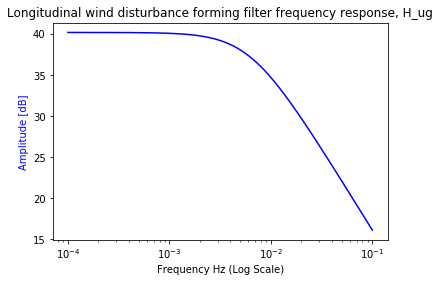

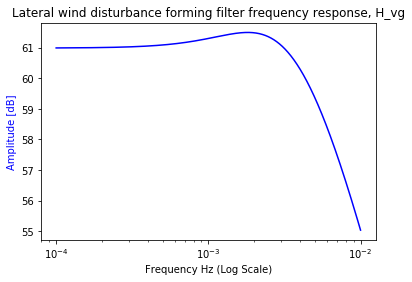

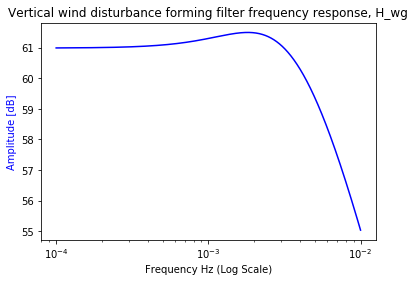

Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground
Quadrotor Collided with the ground



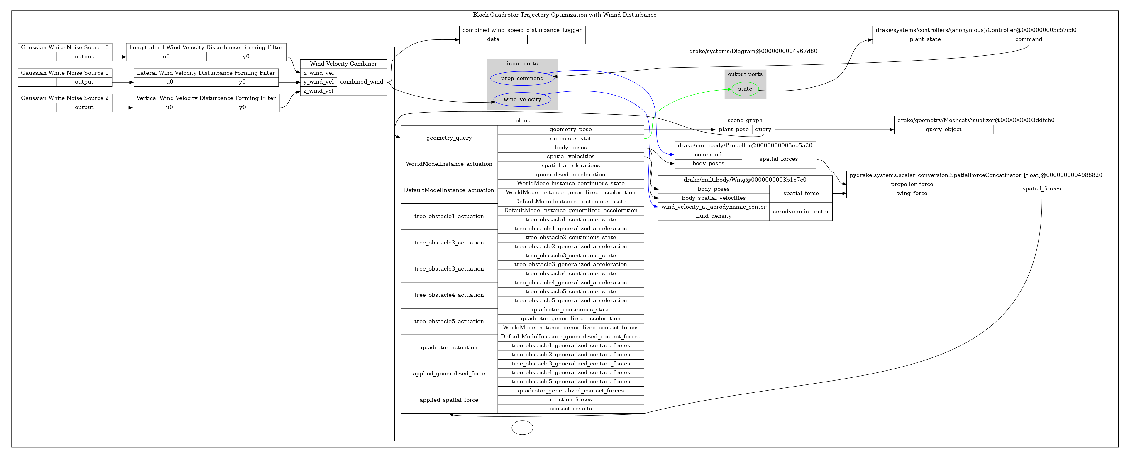

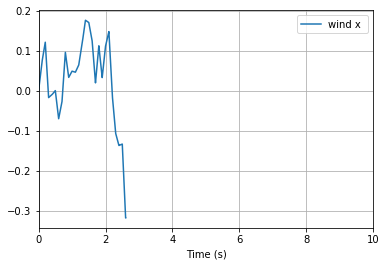

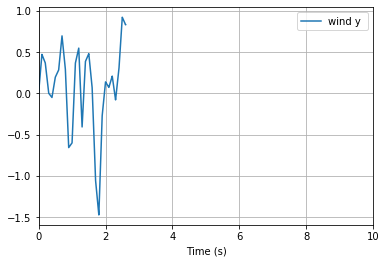

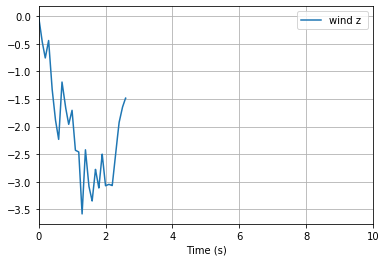

In [8]:

# Simulate nonlinear trajectory optimization + LQR stabilization of quadrotor
def run_non_linear_traj_opt_plus_lqr():

    global fig_num

    #calculate optimal trajectory and simulation
    initial_state = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # target state for trajectory optimization
    final_state = [2, 6, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # limit of thrust force for each individual propellor
    thrust_limit = 10.0
    #we want to have an odd number
    num_time_samples = 21
    
    #insantiate builder to connect high level system components
    world_builder = DiagramBuilder()

    # instatiate builder to build quadrotor by connecting MultiBodyPlant + Propellers
    quadrotor_builder = DiagramBuilder()

    # instantiate traj opt class, used to implement nonlinear traj opt, lqr traj stabilization, linear mpc
    quad_traj_opt = QuadrotorTrajOpt(initial_state, final_state, num_time_samples, thrust_limit)

    # define world multibody plant containing quadrotor body and obstacles
    world_plant, scene_graph = AddMultibodyPlantSceneGraph(quadrotor_builder, time_step = 0.0)

    # world_plant = MultibodyPlant(time_step = 0.0)
    # scene_graph = world_builder.AddSystem(SceneGraph())

    ##################### load obtacle course files  #######################
    obstacles = []
    obs_height = 1.5
    obs_width = 1.3
    obs_depth = 1.3
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[2, 2, 0.5],"tree_body", 
        obs_height, obs_width, obs_depth))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[-2, 2, 0.5], "tree_body", 
        obs_height, obs_width, obs_depth))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[0, 2, 0.5], "tree_body", 
        obs_height, obs_width, obs_depth))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle4.sdf",[1.5, 4, 0.5],"tree_body", 
        obs_height, obs_width, obs_depth))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle5.sdf",[-1.5, 4, 0.5], "tree_body", 
        obs_height, obs_width, obs_depth))


    ####### Import .urdf files, connect quad body to propellers, connect geometry to scene graph
    built_quadrotor, visualizer = create_quadrotor(quadrotor_builder, world_plant, scene_graph, obstacles)

    ####### Add quadrotor to top level diagram builder #####
    world_builder.AddSystem(built_quadrotor)

    # quadrotor_context = built_quadrotor.CreateDefaultContext()

    world_context = world_plant.CreateDefaultContext()

    # cont_state = quadrotor_context.get_state().get_continuous_state()
    # state_vector = cont_state.get_vector()

    # print(cont_state.size())
    # print(state_vector)


    # # fix wind velocity input port to 0
    # built_quadrotor.get_input_port(1).FixValue(quadrotor_context, [0.,0.,0.])


    quadrotor_plant = QuadrotorPlant()
    quadrotor_context =  quadrotor_plant.CreateDefaultContext()

    # # run nonlinear traj opt to generate optimal trajectory offline
    u_trajectory, x_trajectory = quad_traj_opt.dir_col_opt(quadrotor_plant, quadrotor_context, obstacles)
    # u_trajectory, x_trajectory = quad_traj_opt.dir_col_opt(built_quadrotor, quadrotor_context, obstacles)

    print("trajectory optimization completed")
    # input_source = world_builder.AddSystem(TrajectorySource(u_trajectory))
    # world_builder.Connect(input_source.get_output_port(0), built_quadrotor.get_input_port(0) )


    # # # define lqr stabilizing controller to regulate quadrotor toward desired optimal trajectory
    # lqr_regulator, options = quad_traj_opt.create_lqr_stabilizer(x_trajectory, u_trajectory, built_quadrotor, quadrotor_context)
    lqr_regulator, options = quad_traj_opt.create_lqr_stabilizer(x_trajectory, u_trajectory, quadrotor_plant, quadrotor_context)

    # # add the quadrotor and lqr controller to the builder
    lqr_regulator = world_builder.AddSystem(lqr_regulator)


    # # get the end time defined by the trajectory optimization, in order to tell simulation when to complete
    end_time = options.u0.end_time()


    # # # # connect the LQR controller to the quadrotor
    world_builder.Connect(lqr_regulator.get_output_port(0), built_quadrotor.get_input_port(0))
    world_builder.Connect(built_quadrotor.get_output_port(0), lqr_regulator.get_input_port(0))



    ##################### Create Dryden Wind Disturbance Model ################

    sampling_interval = 0.1 # seconds
    altitude = 3000 #ft
    wind_speed = 40 # knots (worst case parameters) ~ 50 MPH
    vehicle_speed = 11 # m/s (specify worst case parameters) DJI Mavic II Pro has top speed of 20 m/s

    dryden = DrydenWindDisturbance(sampling_interval)
    wind_disturbance_src = dryden.create_wind_disturbance_model(altitude, wind_speed,vehicle_speed, world_builder)

    ################ Connect wind disturbance output to wind velocity input on wing of quadrotor 
    world_builder.Connect(wind_disturbance_src.get_output_port(0), built_quadrotor.get_input_port(1))

    logger_wind = LogVectorOutput(wind_disturbance_src.get_output_port(), world_builder)
    logger_wind.set_name('combined wind_speed_disturbance_Logger')


    # # #connect loggers to log state and input over the course of sim
    # input_logger = LogVectorOutput(lqr_regulator.get_output_port(0), world_builder)
    # state_logger = LogVectorOutput(world_plant.get_output_port(0), builder)


    # Set up a simulator to run this diagram
    diagram = world_builder.Build()


    simulator = Simulator(diagram)
    sim_context = simulator.get_mutable_context()
    # sim_context.SetContinuousState(initial_state)
    # cont_state = sim_context.get_continuous_state()


    # fix wind velocity and propeller force input ports for testing
    quadrotor_context = built_quadrotor.GetMyMutableContextFromRoot(sim_context)
    quadrotor_context.SetContinuousState(initial_state)
    # built_quadrotor.get_input_port(1).FixValue(quadrotor_context, [2.,1.,-1])
    # built_quadrotor.get_input_port(0).FixValue(quadrotor_context, [2.,2.,2.,2.])


    # end_time = 10.0
    simulator.set_target_realtime_rate(10.0)
    meshcat.AddButton('Stop Simulation')

    visualizer.StartRecording()
    while simulator.get_context().get_time() < end_time:

        for obs in obstacles:
            if (obs.detect_collision( quadrotor_context) ):
                print("Obstacle collision detected ", obs.position)

        quad_state = quadrotor_context.get_continuous_state().get_vector().CopyToVector()
        if(quad_state[2] < 0):
            print("Quadrotor Collided with the ground")

        simulator.AdvanceTo(simulator.get_context().get_time() + 0.1)
        # print(f"quad_context continous state vector = {cont_state.get_vector()}")

    meshcat.DeleteAddedControls()

    visualizer.StopRecording()
    visualizer.PublishRecording()

    # fig, ax = plt.subplots(2,1)
    # ax[0].plot(options.u0.get_segment_times(),
    #             options.u0.vector_values(options.u0.get_segment_times()).T)
    # input_log = input_logger.FindLog(simulator.get_context())
    # ax[0].plot(input_log.sample_times(), input_log.data().T)
    # ax[0].legend(('u nominal','u actual'))

    # ax[1].plot(options.x0.get_segment_times(),
    #             options.x0.vector_values(options.x0.get_segment_times()).T, 'b')
    # state_log = state_logger.FindLog(simulator.get_context())
    # ax[1].plot(state_log.sample_times(), state_log.data().T, 'g')
    # ax[1].legend(('x nominal','x actual'))
    # display(plt.show())

    ############### Visualize 
    # give names to the blocks (just to make the plot nicer)
    diagram.set_name('Block Quadrotor Trajectory Optimization with Winnd Disturbance')
    # plot current diagram
    plt.figure(fig_num, figsize=(20, 10))
    fig_num += 1
    plot_system_graphviz(diagram)

    ############### Plot Combined wind velocities ######################

    plt.figure(fig_num)
    fig_num +=1
    # longitudinal wind velocity as a function of time
    wind_log = logger_wind.FindLog(sim_context)
    wind_data = wind_log.data()
    print()

    plt.plot(
        wind_log.sample_times(),
        wind_data[0],
        label='wind x '
    )

    # misc plot settings
    plt.xlabel('Time (s)')
    plt.xlim(0, sim_time)
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.plot(
        wind_log.sample_times(),
        wind_data[1],
        label='wind y '
    )

    # misc plot settings
    plt.xlabel('Time (s)')
    plt.xlim(0, sim_time)
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.plot(
        wind_log.sample_times(),
        wind_data[2],
        label='wind z '
    )

    # misc plot settings
    plt.xlabel('Time (s)')
    plt.xlim(0, sim_time)
    plt.grid(True)
    plt.legend()
    plt.show()








# Simulate nonlinear trajectory optimization + LQR stabilization of quadrotor
run_non_linear_traj_opt_plus_lqr()




## Run Linear MPC Simulation

In [9]:
def run_linear_mpc():

    #calculate optimal trajectory and simulation
    initial_state = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    # target state for trajectory optimization
    final_state = [0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    # limit of thrust force for each individual propellor
    thrust_limit = 10.0
    
    #we want to have an odd number
    num_time_samples = 40
    # number of samples into future we will run trajectory optimization
    time_horizon = 40

    # instatiate diagram builder used to connect the different system components
    builder = DiagramBuilder()

    # define world multibody plant & scene graph, containing obstacles and quadrotor
    world_plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)

    # instantiate traj opt class, used to implement nonlinear traj opt, lqr traj stabilization, linear mpc
    quad_traj_opt = QuadrotorTrajOpt(initial_state, final_state, num_time_samples, thrust_limit)

    # add obstacles to the simulated world
    obstacles = []
    obs_height = 1.5
    obs_width = 1.3
    obs_depth = 1.3
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle1.sdf",[2, 2, 0.5],"tree_body", 
        obs_height, obs_width, obs_depth))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle2.sdf",[-2, 2, 0.5], "tree_body", 
        obs_height, obs_width, obs_depth))
    obstacles.append(Obstacle("/work/Quadrotor_MPC/tree_obstacle3.sdf",[0, 4, 0.5], "tree_body", 
        obs_height, obs_width, obs_depth))

    for obs in obstacles:
        obs.connect_obstacle_to_world(world_plant, scene_graph)

    #finalize the world plant
    world_plant.Finalize()



    # define the quadrotor plant using drake built in quadrotor plant class
    # this is a System, not a MultiBodyPlant
    quadrotor_plant = QuadrotorPlant()
    quadrotor_plant = builder.AddSystem(quadrotor_plant)

    initial_thrust = [0., 0., 0., 0.]
    time_step = 0.1
    mpc_controller = MpcController(quadrotor_plant, initial_state, final_state, time_horizon, 
    num_time_samples, thrust_limit, obstacles, initial_thrust, time_step)
    mpc_controller = builder.AddSystem(mpc_controller)

    print(mpc_controller.get_output_port(0).get_data_type())
    print(mpc_controller.get_output_port(0).size())
    print(quadrotor_plant.get_output_port(0).get_data_type())
    print(quadrotor_plant.get_output_port(0).size())

    # connect the MPC controller to the quadrotor
    builder.Connect(mpc_controller.get_output_port(0), quadrotor_plant.get_input_port(0))
    builder.Connect(quadrotor_plant.get_output_port(0), mpc_controller.get_input_port(0))

    # quad_context = quadrotor_plant.CreateDefaultContext()
    # print(quadrotor_plant.get_input_port(0).HasValue(quad_context))


    # Set up visualization in MeshCat
    QuadrotorGeometry.AddToBuilder(builder, quadrotor_plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    ################# Run Simulation ####################
    #Set up a simulator to run this diagram
    diagram = builder.Build()

    quad_context = quadrotor_plant.CreateDefaultContext()
    print(quadrotor_plant.get_input_port(0).HasValue(quad_context))



    simulator = Simulator(diagram)
    sim_context = simulator.get_mutable_context()
    sim_context.SetContinuousState(initial_state)

    # print(f"Collsion detected? {obstacles[0].detect_collision(sim_context)}")

    # pass sim context into MpC controller to be used for linearization of dynamics
    mpc_controller.set_sim_context(sim_context)
    quadrotor_context = quadrotor_plant.GetMyMutableContextFromRoot(sim_context)

    # quadrotor_plant.get_input_port(0).FixValue(quadrotor_context, [10.,10.,10.,10.])
    end_time = 10.0
    simulator.set_target_realtime_rate(10.0)
    meshcat.AddButton('Stop Simulation')
    while simulator.get_context().get_time() < end_time:

        simulator.AdvanceTo(sim_context.get_time() + 0.5)

    meshcat.DeleteAddedControls()

# Simulate MPC of quadrotor
# run_linear_mpc()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=252d90d3-1ad4-4a56-8b32-ebf5b097846b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>